In [85]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style("white")
sns.set(context='notebook',
        style='ticks',
        font_scale=1,
        rc={'axes.grid':True,
            'grid.color':'.9',
            'grid.linewidth':0.75})
from joblib import Parallel, delayed
import scipy.optimize as optimize
from scipy.optimize import minimize_scalar, brute
from tqdm import tqdm
from matplotlib.ticker import FormatStrFormatter, MaxNLocator

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import sys
import os
sys.path.insert(0, os.path.dirname(os.getcwd()))

### Summary Plot

In [86]:
def generate_in_distribution_data(n, mu, sigma, pi_in):
    n_1 = round(n*pi_in)
    n_0 = round(n*(1-pi_in))
    mu_1 = mu
    mu_0 = -mu_1
    X_0 = np.random.normal(mu_0, sigma, n_0)
    X_1 = np.random.normal(mu_1, sigma, n_1)
    X = np.concatenate((X_0, X_1))
    Y = np.concatenate((np.zeros(n_0), np.ones(n_1)))
    return X, Y

def generate_out_distribution_data(n, mu, sigma, pi_out, delta):
    n_1 = round(n*pi_out)
    n_0 = round(n*(1-pi_out))
    mu_1 = mu + delta
    mu_0 = -mu + delta
    X_0 = np.random.normal(mu_0, sigma, n_0)
    X_1 = np.random.normal(mu_1, sigma, n_1)
    X = np.concatenate((X_0, X_1))
    Y = np.concatenate((np.zeros(n_0), np.ones(n_1)))
    return X, Y

def get_data(n, m, mu, sigma, delta, pi_in=0.5, pi_out=0.5):
    np.random.seed(10)
    X, Y = generate_in_distribution_data(n, mu, sigma, pi_in)
    np.random.seed(10)
    X_o, Y_o = generate_out_distribution_data(m, mu, sigma, pi_out, delta)

    df = pd.DataFrame()
    df['data'] = np.concatenate((X[Y==0], X[Y==1], X_o[Y_o==0], X_o[Y_o==1]))
    df['class'] = np.concatenate((Y[Y==0], Y[Y==1], Y_o[Y_o==0], Y_o[Y_o==1]))
    tasks = ["t1" for x in range(len(Y))]
    tasks.extend(["t2" for x in range(len(Y_o))])
    df['task'] = tasks
    df.task = df.task.astype("category")
    return df

def expected_risk(n, m, mu, sigma, delta):
    mu_h = (m/(n+m))*delta
    sigma_h = sigma*np.sqrt(1/(n+m))
    risk = 0.5*(1 + norm.cdf((mu_h - mu)/(np.sqrt(sigma**2 + sigma_h**2))) - norm.cdf((mu_h + mu)/(np.sqrt(sigma**2 + sigma_h**2))))
    return risk


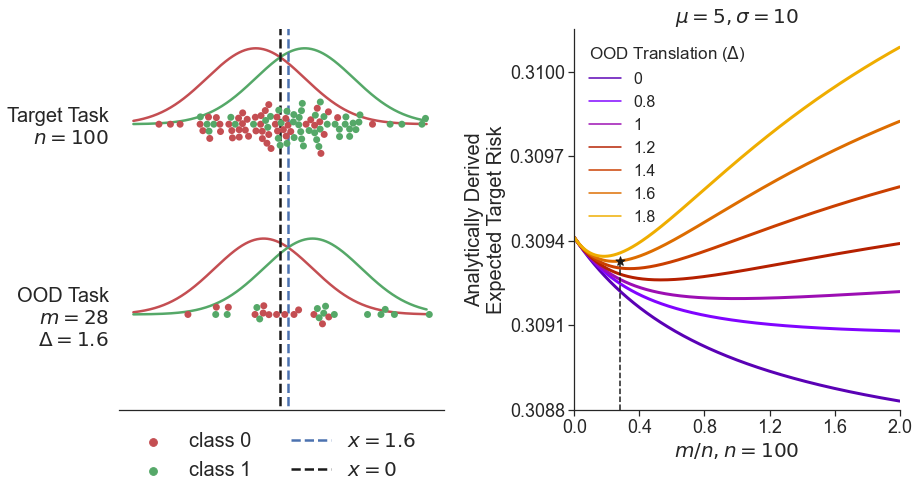

In [88]:
fontsize = 20
labelsize = 18
lw = 2.5

n = 100
m = 28
mu = 5
sigma = 10
delta = 1.6
xlim = 30
scale = 10

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
sns.despine()
sns.set_palette("pastel")
ax = axes[0]
df = get_data(n, m, mu, sigma, delta)

# plot the beeswarm plot
ax = sns.swarmplot(x='data', y='task', hue='class', data=df, ax=ax, palette=['r', 'g'], size=7)
markers = ax.get_children()

rv = norm(loc=-mu, scale=sigma)
x = np.arange(-xlim, xlim, 0.1)
ax.plot(x, -scale*rv.pdf(x), 'r', lw=lw)
rv = norm(loc=mu, scale=sigma)
x = np.arange(-xlim, xlim, 0.1)
ax.plot(x, -scale*rv.pdf(x), 'g', lw=lw)

rv = norm(loc=-mu+delta, scale=sigma)
x = np.arange(-xlim, xlim, 0.1)
ax.plot(x, -scale*rv.pdf(x)+1, 'r', lw=lw)
rv = norm(loc=mu+delta, scale=sigma)
x = np.arange(-xlim, xlim, 0.1)
ax.plot(x, -scale*rv.pdf(x)+1, 'g', lw=lw)

ax.set_xticks([])
line1 = ax.vlines(delta, -1, 2, linestyle='dashed', color='b', label=r"$x = {}$".format(delta), lw=lw)
line2 = ax.vlines(0, -1, 2, linestyle='dashed', color='k', label=r"$x = 0$", lw=lw)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_yticks([0, 1])
ax.set_yticklabels(["Target Task" + "\n" r"$n = 100$", "OOD Task" +"\n" + r"$m=28$" +"\n" + r"$\Delta=1.6$"])
ax.get_legend().remove()
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
ax.spines[['right', 'top', 'left']].set_visible(False)
ax.tick_params(left=False)

plt.figlegend(
    [markers[2], markers[3], line1, line2],
    ["class 0", "class 1", r"$x = {}$".format(delta), r"$x = 0$"],
    loc=8,
    ncol=2,
    fontsize=fontsize,
    bbox_to_anchor=(0.28, -0.05),
    frameon=False
)

ax = axes[1]

n = 100
mmax = 200
mu = 5
sigma = 10
Delta = [0, 0.8, 1, 1.2, 1.4, 1.6, 1.8] # n = 100

m_sizes = np.arange(0, mmax+1e-4, 0.1)
i = 0
df = pd.DataFrame()
for m in m_sizes:
    df.at[i, "m"] = m/n
    for delta in Delta:
        df.at[i, str(delta)] = expected_risk(n, m, mu, sigma, delta)
    i+=1

m_sizes = np.arange(0, mmax+1, 1)
i = 0
df1 = pd.DataFrame()
for m in m_sizes:
    df1.at[i, "m"] = m/n
    for delta in Delta:
        df1.at[i, str(delta)] = expected_risk(n, m, mu, sigma, delta)
    i+=1

dfm = df.melt(['m'], var_name='Delta', value_name='Risk')
ax = sns.lineplot(data=dfm, x="m", y="Risk", hue="Delta", ax=ax, markers=["o"], ci=95, lw=3, palette='gnuplot')
ax.set_ylabel("Analytically Derived" + "\n" + "Expected Target Risk", fontsize=fontsize)
ax.set_xlabel(r"$m/n, n={}$".format(n), fontsize=fontsize)
ax.tick_params(axis='x', labelsize=labelsize)
ax.tick_params(axis='y', labelsize=labelsize)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.set_xlim([min(m_sizes/n), max(m_sizes/n)])
leg = ax.legend(title=r"OOD Translation ($\Delta$)", fontsize=labelsize-2, title_fontsize=labelsize-1, frameon=False)
leg._legend_box.align = "left"
ax.set_title(r"$\mu = {}, \sigma = {}$".format(mu, sigma), fontsize=fontsize)
ax.grid(False)
risk0 = expected_risk(100,28,5,10,1.6)
ax.scatter([0.28], [risk0], marker='*', s=90, c='k', zorder=10)
ax.vlines(0.28, 0.3088, risk0, linestyle='dashed', color='k')
ax.set_ylim([0.3088, ax.get_ylim()[1]])

# left  = 0.125  # the left side of the subplots of the figure
# right = 0.9    # the right side of the subplots of the figure
# bottom = 0.1   # the bottom of the subplots of the figure
# top = 0.9      # the top of the subplots of the figure
wspace = 0.3   # the amount of width reserved for blank space between subplots
# hspace = 0.2   # the amount of height reserved for white space between subplots
plt.subplots_adjust(wspace = 0.4)

plt.show()

In [89]:
fig.savefig("../paper/figs/1-summary-plot.pdf", bbox_inches="tight")

### Bias-Variance Breakdown Plot

In [90]:
def get_bias_variance(n, m, mu, sigma, delta):
    mu_h = (m/(n+m))*(delta/sigma)
    mu = mu/sigma
    sigma_h = np.sqrt(1/(n+m))
    bias = mu_h**2
    variance = sigma_h**2
    return bias, variance

In [91]:
delta = 1.8
mu = 5
sigma = 10
n = 100
m_sizes = np.arange(0, 201, 0.1)

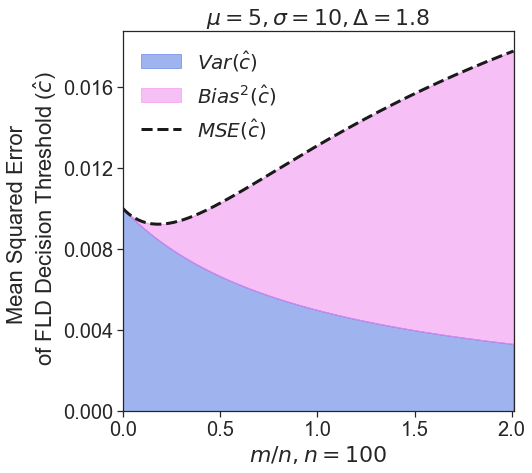

In [92]:
fig, ax = plt.subplots(figsize=(7,7))
fontsize = 22
labelsize = 20
lw = 3

bias_squared = []
variance = []
for m in m_sizes:
    temp = get_bias_variance(n, m, mu, sigma, delta)
    bias_squared.append(temp[0])
    variance.append(temp[1])

bias_squared = np.array(bias_squared)
variance = np.array(variance)
mse = bias_squared + variance

ax.fill_between(m_sizes/n, variance, step="pre", alpha=0.5, color='royalblue', label=r"$Var(\hat c)$")
ax.fill_between(m_sizes/n, variance, variance + bias_squared, step="pre", alpha=0.5, color='violet', label=r"$Bias^2(\hat c)$")
ax.plot(m_sizes/n, mse, c='k', lw=lw, ls='--', label=r"$MSE(\hat c)$")

ax.set_xlabel(r"$m/n, n={}$".format(n), fontsize=fontsize)
ax.set_ylabel("Mean Squared Error \n of FLD Decision Threshold" + r" ($\hat c$)".format(n), fontsize=fontsize)
ax.set_title(r"$\mu=5, \sigma=10, \Delta=1.8$", fontsize=fontsize)
ax.tick_params(axis='x', labelsize=labelsize)
ax.tick_params(axis='y', labelsize=labelsize)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(5))
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f')) # n = 100
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f')) # n = 4
ax.set_xlim([min(m_sizes/n), max(m_sizes/n)])
ax.set_ylim([0, mse.max()+0.001])
ax.legend(fontsize=labelsize, frameon=False)
ax.grid(False)
plt.show()


In [93]:
fig.savefig("../paper/figs/2-bias-var-breakdown-plot.pdf", bbox_inches="tight")

### Large Target Sample Size Plot

In [ ]:
n = 500
mmax = 1000
mu = 6
sigma = 16
Delta = [0, 0.8, 1, 1.2, 1.4, 1.6, 1.8]

m_sizes = np.arange(0, mmax+1e-4, 0.1)
i = 0
df = pd.DataFrame()
for m in m_sizes:
    df.at[i, "m"] = m/n
    for delta in Delta:
        df.at[i, str(delta)] = expected_risk(n, m, mu, sigma, delta)
    i+=1

m_sizes = np.arange(0, mmax+1, 1)
i = 0
df1 = pd.DataFrame()
for m in m_sizes:
    df1.at[i, "m"] = m/n
    for delta in Delta:
        df1.at[i, str(delta)] = expected_risk(n, m, mu, sigma, delta)
    i+=1

dfm = df.melt(['m'], var_name='Delta', value_name='Risk')
fig, ax = plt.subplots(figsize=(7, 7), facecolor='white')
ax = sns.lineplot(data=dfm, x="m", y="Risk", hue="Delta", ax=ax, markers=["o"], ci=95, lw=3, palette='gnuplot')
ax.set_ylabel("Analytically Derived" + "\n" + "Expected Target Risk", fontsize=fontsize)
ax.set_xlabel(r"$m/n, n={}$".format(n), fontsize=fontsize)
ax.tick_params(axis='x', labelsize=labelsize)
ax.tick_params(axis='y', labelsize=labelsize)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f')) # n = 4
ax.set_xlim([min(m_sizes/n), max(m_sizes/n)])
# ax.set_xlim([0, 2.5])
leg = ax.legend(title=r"OOD Translation ($\Delta$)", fontsize=labelsize-1, title_fontsize=labelsize-1, frameon=False)
leg._legend_box.align = "left"
ax.set_title(r"$\mu = {}, \sigma = {}$".format(mu, sigma), fontsize=fontsize)
sns.despine()
ax.grid(False)
plt.show()

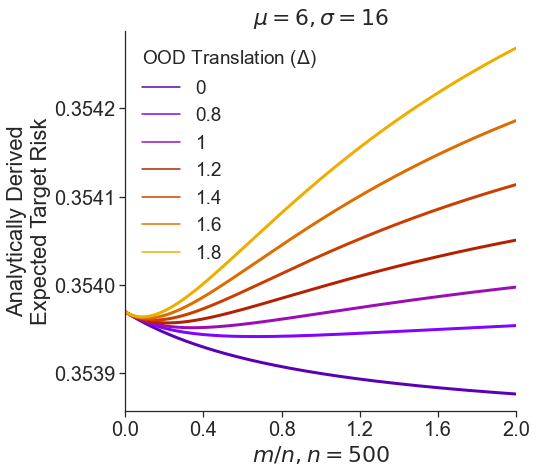

In [101]:
fig.savefig("../paper/figs/3-large-target-samplesize-plot.pdf", bbox_inches="tight")